In [2]:
#### Load in data ####

import os
import cv2
import numpy as np
import pandas as pd
from itertools import product
from tqdm import tqdm
from utils import load_images_by_domain, split_images

# Define paths
img_dir = "../OfficeCaltechDomainAdaptation/images"

# Load images by domain
data_by_domain = load_images_by_domain(
    img_dir=img_dir,
    target_size=(300, 300),  # Standardized size
    method="pad",           # Use padding to maintain aspect ratio
    seed=888                # Seed for reproducibility
)

# Split images: Combine amazon and caltech10 into train/val/test
train_data, val_data, test_data = split_images(
    data_by_domain=data_by_domain,
    train_domains=["amazon", "caltech10"],  # Combine these for training and validation
    test_domains=[],                        # Use part of amazon and caltech10 for testing
    train_split=0.6,                        # 60% for training
    val_split=0.2,                          # 20% for validation
    use_train_for_test=True,                # Use part of train_domains for testing
    test_split=0.2,                         # 20% for testing
    seed=888                                # Seed for reproducibility
)

# Summary of splits
print(f"Train images: {len(train_data['images'])}, Train labels: {len(train_data['labels'])}")
print(f"Validation images: {len(val_data['images'])}, Validation labels: {len(val_data['labels'])}")
print(f"Test images: {len(test_data['images'])}, Test labels: {len(test_data['labels'])}")



Train images: 1247, Train labels: 1247
Validation images: 415, Validation labels: 415
Test images: 419, Test labels: 419


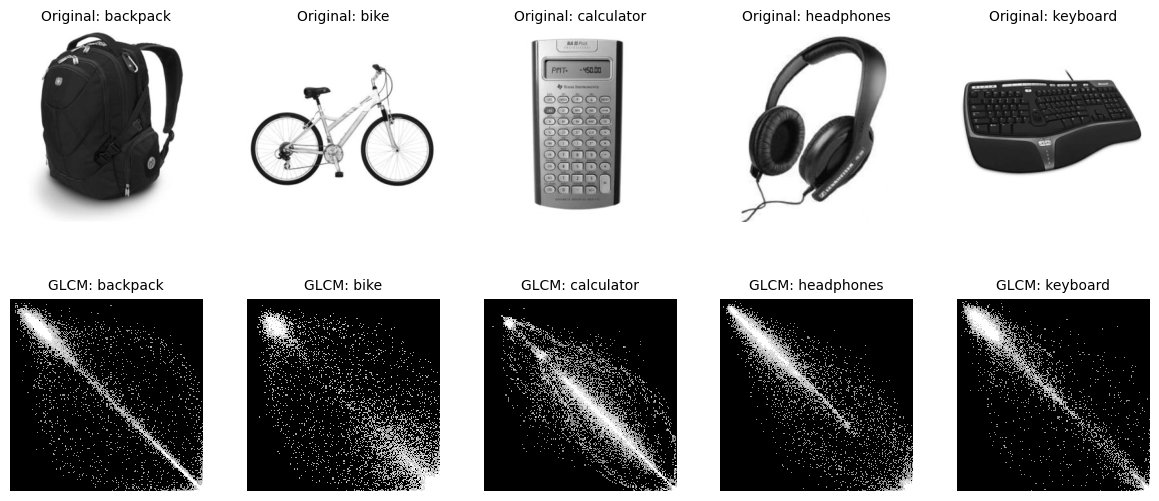

In [34]:
import cv2
import numpy as np
from skimage.exposure import equalize_hist
import matplotlib.pyplot as plt

def normalize_glcm(glcm, clip_percentile=99):
    """
    Normalize the GLCM for visualization, applying thresholding and scaling.
    """
    # Clip extremely small values (optional)
    max_value = np.percentile(glcm, clip_percentile)  # Top percentile of values
    glcm[glcm > max_value] = max_value  # Clip outliers

    # Normalize GLCM to 0-255
    glcm_normalized = (glcm / max_value * 255).astype(np.uint8)
    return glcm_normalized

def compute_and_visualize_glcm(image, distance=1, angle=0, levels=256, output_size=(300, 300)):
    """
    Compute and visualize GLCM for a given image with enhancements for better visualization.
    """
    # Convert to grayscale if necessary
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute GLCM
    glcm = compute_glcm(gray_image, distance, angle, levels=levels)

    # Normalize GLCM for visualization
    glcm_normalized = normalize_glcm(glcm, clip_percentile=99)

    # Resize GLCM to match the desired resolution
    glcm_resized = cv2.resize(glcm_normalized, output_size, interpolation=cv2.INTER_NEAREST)

    # Apply histogram equalization for better contrast
    glcm_equalized = equalize_hist(glcm_resized)  # Stretch to full dynamic range
    glcm_equalized = (glcm_equalized * 255).astype(np.uint8)

    return gray_image, glcm_equalized

# Assuming selected_images and selected_categories are defined
original_images = []
glcm_images = []

for image in selected_images:
    original, glcm = compute_and_visualize_glcm(image, distance=1, angle=0, levels=256, output_size=(300, 300))
    original_images.append(original)
    glcm_images.append(glcm)

def plot_glcm_results(original_images, glcm_images, categories):
    """
    Plot original images in a single row and their corresponding GLCMs in another row with specific labels.
    """
    num_categories = len(categories)
    
    # Create a grid with 2 rows: one for original images, one for GLCMs
    fig, axes = plt.subplots(2, num_categories, figsize=(15, 6))
    
    # Plot original images in the top row
    for i, category in enumerate(categories):
        axes[0, i].imshow(original_images[i], cmap='gray')
        axes[0, i].set_title(f"Original: {category}", fontsize=10)  # Dynamic title
        axes[0, i].axis('off')

    # Plot GLCMs in the bottom row
    for i, category in enumerate(categories):
        axes[1, i].imshow(glcm_images[i], cmap='gray', interpolation='nearest')
        axes[1, i].set_title(f"GLCM: {category}", fontsize=10)  # Dynamic title
        axes[1, i].axis('off')
    
    # Adjust spacing between plots
    plt.subplots_adjust(wspace=0.1, hspace=0.4)  # Adjust spacing between rows and columns
    
    plt.show()

# Assuming selected_categories is a list of category names
plot_glcm_results(original_images, glcm_images, selected_categories)
